# Layout:

1.	Import Packages/Libraries
2.	Read Dataset From Scrape
3.	Clean Data and add Dummy Variables
    + Remove Duplicate Values
    + Set Column Value Types from Object to Regression-Friendly Values
    + Turn Categorical Data into 0/1 Variables
    + Drop Movies/Anime
4.	Split Data into Train and Test Sets
    + Split Dependent and Independent Variables
    + Make Train/Test Datasets and Turn Training into a DataFrame
    + Remove Outliers from Training Set
5.	Exploratory Data Analysis (EDA) on Train Data
    + Pairplots of All Variables
    + Correlations
6.	Base OLS Model on Original Train Data
    + OLS Fit and Summary
    + K-Fold Validation
    + Plot Predictions vs Actual
    + Diagnostic Plots on Base Model
        + Residuals vs Fitted
        + Normal Q-Q
        + Scale-Location
        + Residuals vs Leverage
8.	Rescale Data As Needed
    + Log and Plot Dependent
    + Attempt Boxcox Transformations and Plot- Ignore Results
9.	EDA on Scaled Data
10.	Regression on Logged Values
    + Drop Multicollinear Elements
    + Run OLS Fit and Summary
    + Run K-Fold CV
    + Plot Predictions vs Actual
	+ Diagnostic Plots on Updated Train Data
        + Residuals vs Fitted
        + Normal Q-Q
        + Scale-Location
        + Residuals vs Leverage
12.	Polynomial Features
13. EDA with Polynomial Data
14.	Regression with Polynomial Features
    + Run OLS Fit and Summary
    + Run K-Fold CV
    + Plot Predictions vs Actual
	+ Diagnostic Plots on Updated Train Data
        + Residuals vs Fitted
        + Normal Q-Q
        + Scale-Location
        + Residuals vs Leverage
15.	Compare Linear and More Complicated Models’ R2 Scores
    + Make Function to Compare with Previously Made K-Folds
    + Run Comparison on Train Data
    + Run on Modified Data
16.	Check Inputs of Best Model on Entire Train Data to Maximize R2 and Minimize Overfitting
17.	Run “Best” Model on Entire Testing Data (Holdout Set)
18.	Plot Final Results

# 1. Mass Importation

In [1]:
import pandas as pd
import numpy as np
import dateutil.parser
from datetime import date
import re

from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy import stats
from sklearn import linear_model,ensemble, tree, model_selection, datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV

import diagnostic_plots

import pickle
import time

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2. Read Dataset from Scrape

In [2]:
df=pd.read_csv('steam3.csv')
del(df['Unnamed: 0'])
df.set_index('title', inplace=True)
df.head()

,link,system,systems,reviews,release_date,discount,price
title,,,,,,,
Warframe,https://store.steampowered.com/app/230410/Warf...,1,['win'],192592,1940,0,0.00
Clicker Heroes 2,https://store.steampowered.com/app/629910/Clic...,2,"['win', 'mac']",183,1,0,29.99
Tom Clancy's Rainbow Six® Siege,https://store.steampowered.com/app/359550/Tom_...,1,['win'],170518,959,0,14.99
Counter-Strike: Global Offensive,https://store.steampowered.com/app/730/Counter...,3,"['win', 'mac', 'linux']",2628652,2156,0,14.99
Grand Theft Auto V,https://store.steampowered.com/app/271590/Gran...,1,['win'],343780,1191,34,29.99


# 3. Clean Data and Add Dummy Variables

## Remove Duplicates

In [3]:
no_dup_df = df[~df.index.duplicated(keep='first')]

## Set Column Value Types

In [4]:
no_dup_df['system'] = no_dup_df.system.astype(int)
no_dup_df['reviews'] = no_dup_df.reviews.astype(int)
no_dup_df['release_date'] = no_dup_df.release_date.astype(int)
no_dup_df['discount'] = no_dup_df.discount.astype(int)
no_dup_df['price'] = no_dup_df.price.astype(float)
no_dup_df['systems'] = no_dup_df.systems.astype(list)

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

## Windows, Mac, Linux -> Dummy Variables

In [5]:
windows=[1 if 'win' in item else 0 for item in no_dup_df.systems]
mac=[1 if 'mac' in item else 0 for item in no_dup_df.systems]
linux=[1 if 'linux' in item else 0 for item in no_dup_df.systems]

In [6]:
no_dup_df['windows']=windows
no_dup_df['mac']=mac
no_dup_df['linux']=linux

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [7]:
no_dup_df['windows'] = no_dup_df.windows.astype(int)
no_dup_df['mac'] = no_dup_df.mac.astype(int)
no_dup_df['linux'] = no_dup_df.linux.astype(int)
#no_dup_df.info()

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

## Drop Streaming Videos

In [8]:
movies=[]
for i in range(len(no_dup_df['systems'])):
    element=(no_dup_df['systems'][i])
    if 'win' not in element and 'mac' not in element and 'linux' not in element:
        movies.append(1)
    else:
        movies.append(0)
no_dup_df['movies']=movies
no_dup_df = no_dup_df[no_dup_df.movies != 1]
del(no_dup_df['movies'])

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# 4. Split Data into Train/Test

## Split Dependent and Independent Variables From Original Dataset

In [9]:
y = no_dup_df['reviews']
X = no_dup_df.drop(['reviews','link','systems'], axis = 1)

## Make Train/Test Sets and Put in DataFrame

In [10]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.3)
tdf=X_t.join(y_t)

## Remove Outliers from Training Set

In [11]:
traindf=tdf[tdf.reviews < 100000]
y_train = traindf['reviews']
X_train = traindf.drop(['reviews'], axis = 1)

# 5. EDA on Train Data

## Pairplot

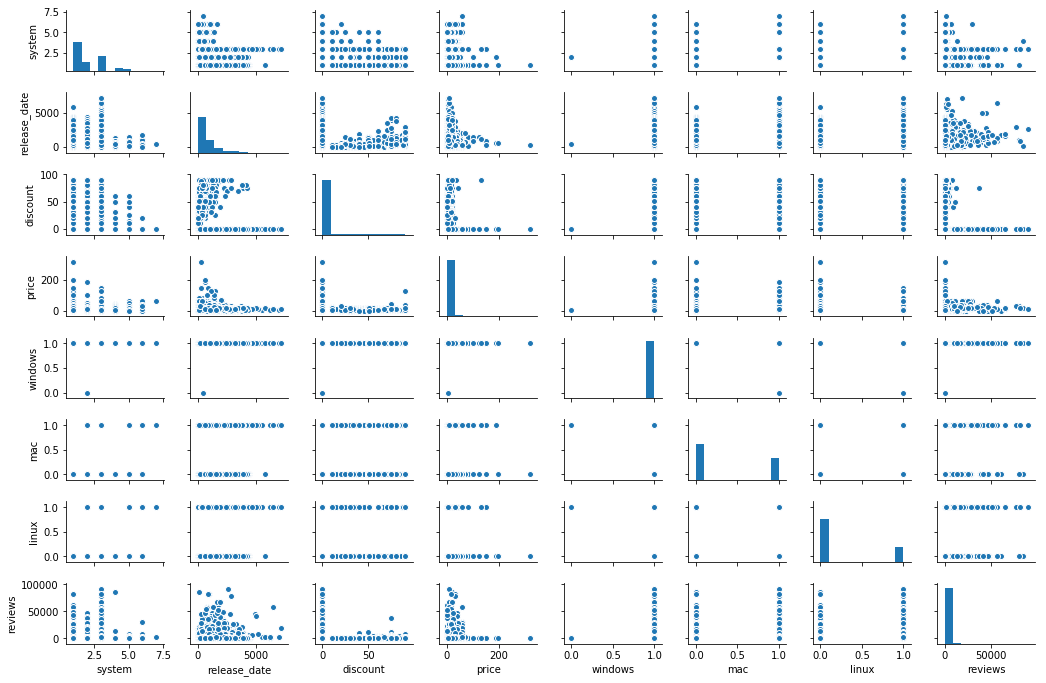

In [12]:
sns.pairplot(traindf, size = 1.2, aspect=1.5)

## Correlation Matrix

In [13]:
traindf.corr()
#sns.heatmap(no_dup_df.corr(), cmap="seismic")

,system,release_date,discount,price,windows,mac,linux,reviews
system,1.000000,-0.088688,-0.038431,0.030116,-0.000596,0.497280,0.531456,0.022767
release_date,-0.088688,1.000000,-0.025981,0.046694,0.004837,0.066305,0.040027,0.193375
discount,-0.038431,-0.025981,1.000000,-0.040441,0.003122,-0.002304,-0.000609,-0.024194
price,0.030116,0.046694,-0.040441,1.000000,0.005299,-0.002418,0.000399,0.161867
windows,-0.000596,0.004837,0.003122,0.005299,1.000000,-0.017508,-0.023104,0.003092
mac,0.497280,0.066305,-0.002304,-0.002418,-0.017508,1.000000,0.655909,0.075115
linux,0.531456,0.040027,-0.000609,0.000399,-0.023104,0.655909,1.000000,0.091846
reviews,0.022767,0.193375,-0.024194,0.161867,0.003092,0.075115,0.091846,1.000000


# 6. Base Model

## OLS Fit and Summary

In [14]:
model = sm.OLS(y_train, sm.add_constant(X_train))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                reviews   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     56.94
Date:                Thu, 19 Jul 2018   Prob (F-statistic):           4.36e-79
Time:                        19:44:31   Log-Likelihood:                -53994.
No. Observations:                5429   AIC:                         1.080e+05
Df Residuals:                    5421   BIC:                         1.081e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1834.3924   5053.486     -0.363      0.717   -1.17e+04    8072.470
system         -93.8014     75.540     -1.242      0.214    -241.890      54.287
release_date     1.0706      0.079     13.487      0.000       0.915       1.226
discount        -5.5959      5.248     -1.066      0.286     -15.884       4.692
price           68.9514      5.904     11.678      0.000      57.377      80.526
windows       1421.9473   5053.136      0.281      0.778   -8484.228    1.13e+04
mac            209.5133    193.582      1.082      0.279    -169.985     589.012
linux          988.8363    219.229      4.511      0.000     559.059    1418.614
==============================================================================
Omnibus:                     7828.390   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2410030.460
Skew:                           8.685   Prob(JB):                         0.00
Kurtosis:                     104.746   Cond. No.                     1.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## K-Fold Validation; Return Average Score Across Folds

### 10-fold Cross Validation Split

In [15]:
kf=KFold(n=len(X_train), n_folds=10, shuffle=True, random_state=20)

### Calculate Avg Score Across Folds

In [16]:
def score(kf,X,y):
    all_scores_lr_train = []
    all_scores_lr_test = []
    for train, test in kf:
        Xt_train = X.iloc[train]
        yt_train=y.iloc[train]
        X_val = X.iloc[test]
        y_val = y.iloc[test]

        lr=LinearRegression()
        lr.fit(Xt_train, yt_train)
        all_scores_lr_train.append(lr.score(Xt_train,yt_train))
        all_scores_lr_test.append(lr.score(X_val,y_val))

    return ('train score mean: ' + str(np.mean(all_scores_lr_train)), 'test score mean: ' + str(np.mean(all_scores_lr_test)))

score(kf,X_train,y_train)

#model does worse than guessing the mean value of y at x
# r20= figure out what mean value of y- only gives average value as 0

('train score mean: 0.06872659306938117',
 'test score mean: 0.059049248221680686')

## Plot Predicted vs Actual

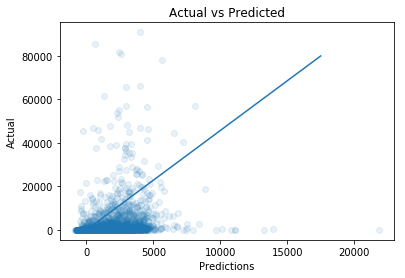

In [17]:
predict = fit.predict(sm.add_constant(X_train))
plt.scatter(predict,y_train,alpha=.1)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot(np.linspace(0,17500,1000),np.linspace(0,80000,1000));
plt.title('Actual vs Predicted');

## Diagnostic Plots on Base Model

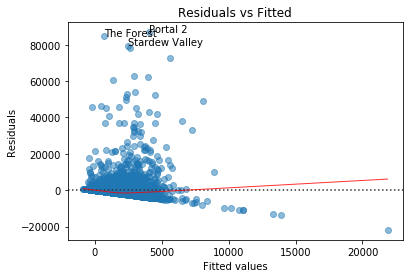

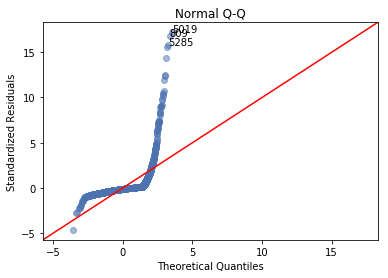

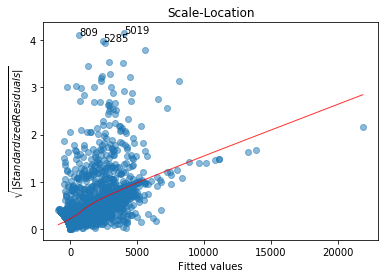

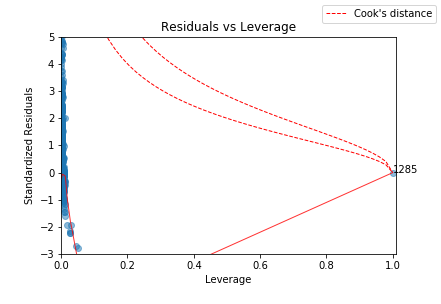

In [18]:
y_traindf=pd.DataFrame(y_train)
X_traindf=pd.DataFrame(X_train)
diagnostic_plots.diagnostic_plots(X_traindf, y_traindf, fit)

#residuals are not normally distributed

# 7. Rescale/Normalize Data

## Log Dependent Data

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([1445.,    0., 1026.,  857.,  716.,  545.,  406.,  260.,  133.,
          41.]),
 array([ 0.        ,  1.14177573,  2.28355146,  3.42532718,  4.56710291,
         5.70887864,  6.85065437,  7.99243009,  9.13420582, 10.27598155,
        11.41775728]),
 <a list of 10 Patch objects>)

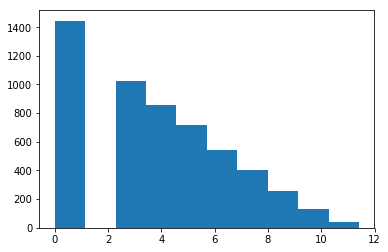

In [19]:
traindf['log_reviews'] = np.log(traindf.reviews + 1)
plt.hist(traindf['log_reviews'])

## Boxcox- makes no difference, stick to log

In [20]:
yt, _ = stats.boxcox(traindf['reviews']+1)

(array([1445.,    0.,  613.,  916.,  701.,  701.,  470.,  318.,  210.,
          55.]),
 array([0.        , 0.94783885, 1.89567771, 2.84351656, 3.79135542,
        4.73919427, 5.68703313, 6.63487198, 7.58271084, 8.53054969,
        9.47838855]),
 <a list of 10 Patch objects>)

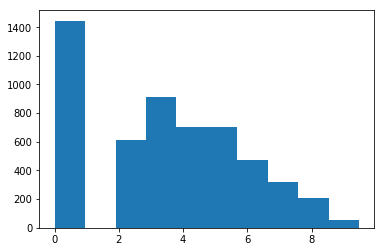

In [21]:
plt.hist(yt)

# 8. EDA on Scaled Data; Log Reviews as Dependent

## Pairplot

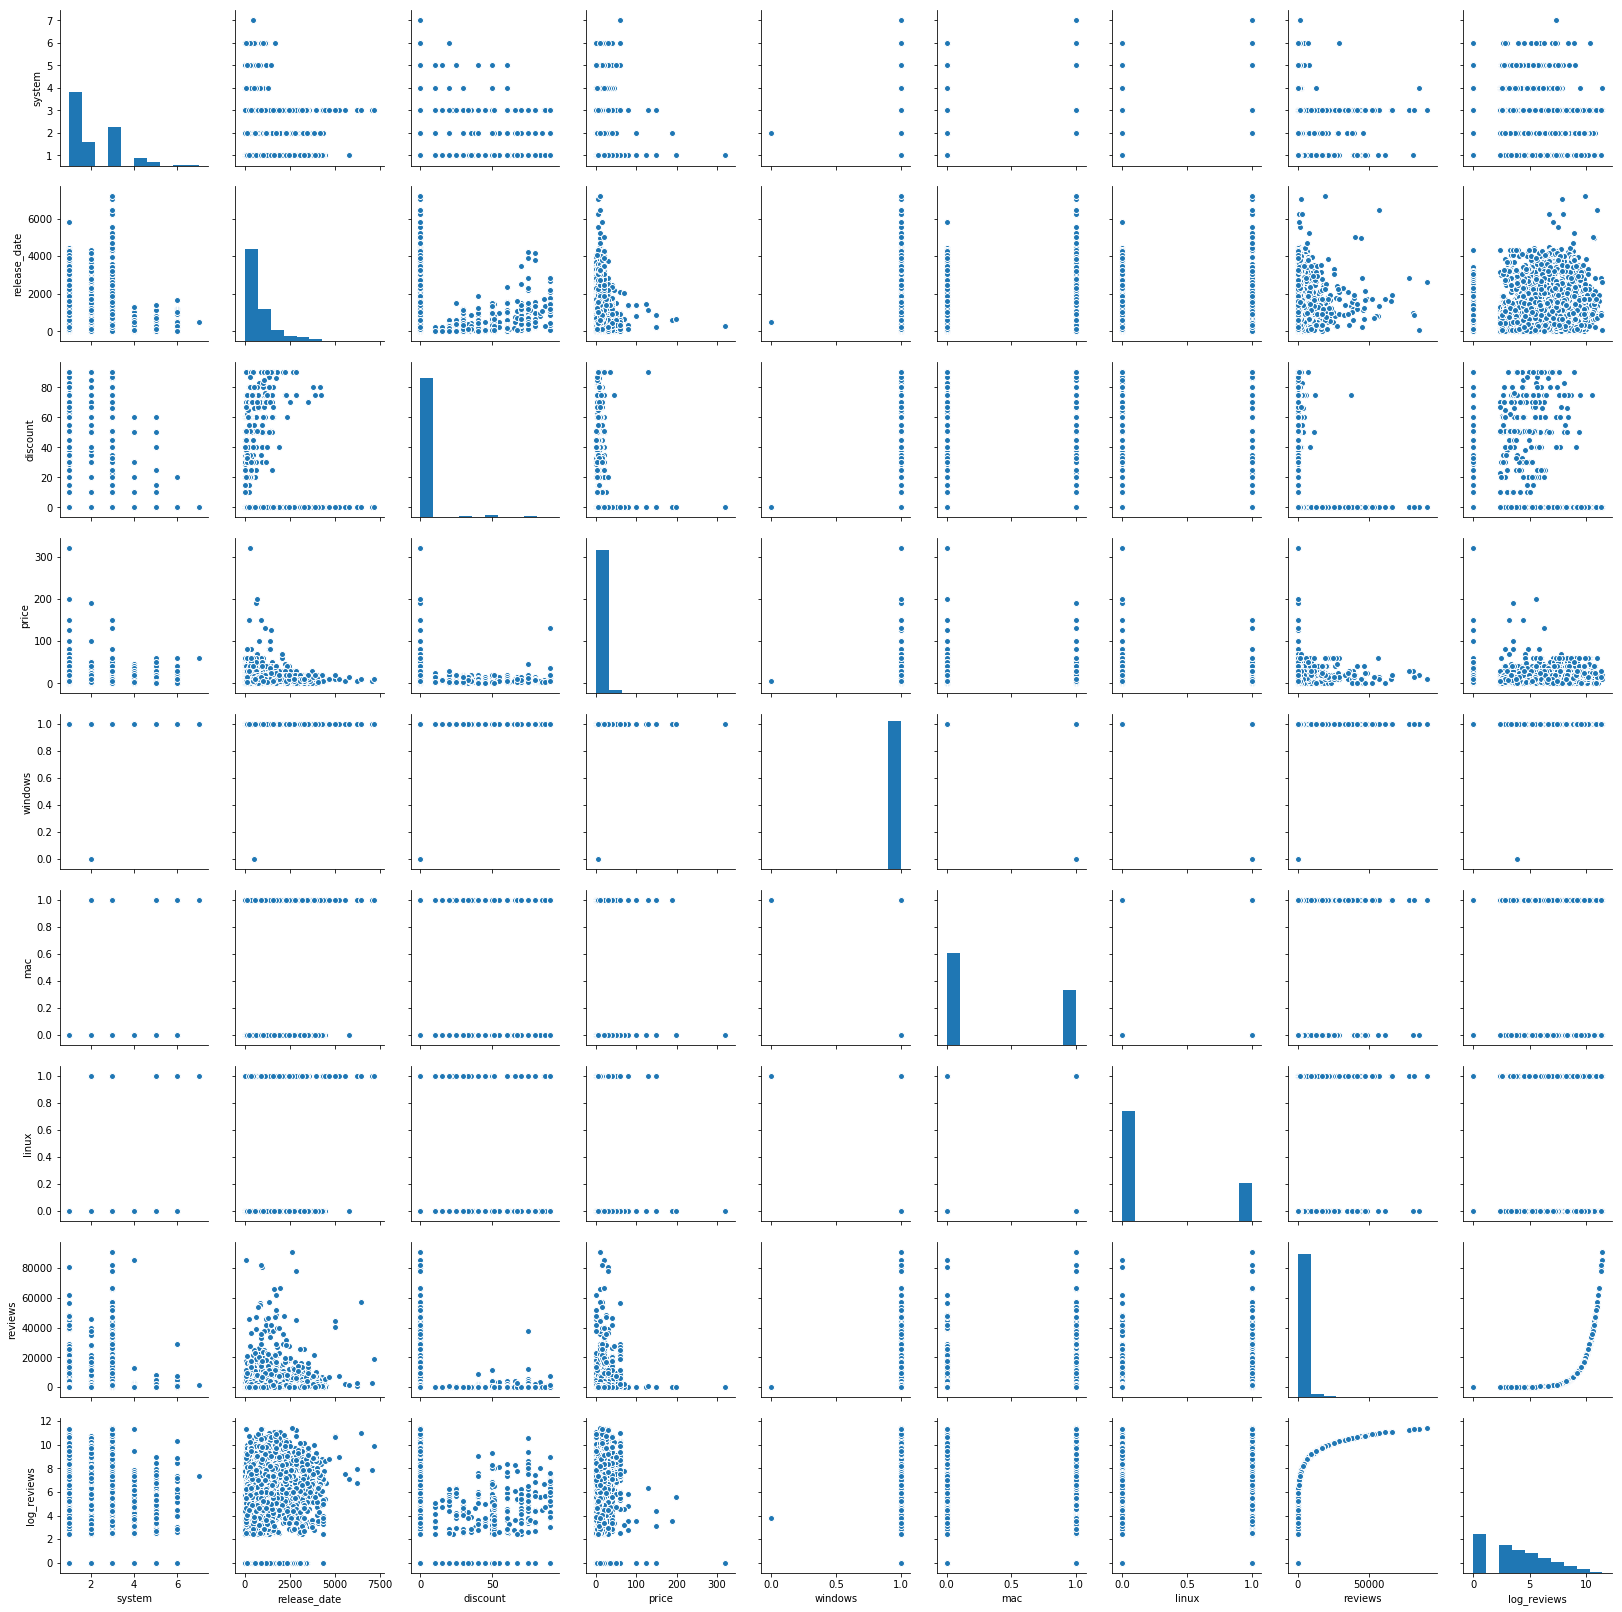

In [22]:
sns.pairplot(traindf)

## Correlation Matrix

In [23]:
traindf.corr()
#windows doesnt seem correlated- because windows is almost columns

,system,release_date,discount,price,windows,mac,linux,reviews,log_reviews
system,1.000000,-0.088688,-0.038431,0.030116,-0.000596,0.497280,0.531456,0.022767,0.060135
release_date,-0.088688,1.000000,-0.025981,0.046694,0.004837,0.066305,0.040027,0.193375,0.402195
discount,-0.038431,-0.025981,1.000000,-0.040441,0.003122,-0.002304,-0.000609,-0.024194,0.007468
price,0.030116,0.046694,-0.040441,1.000000,0.005299,-0.002418,0.000399,0.161867,0.258215
windows,-0.000596,0.004837,0.003122,0.005299,1.000000,-0.017508,-0.023104,0.003092,-0.000357
mac,0.497280,0.066305,-0.002304,-0.002418,-0.017508,1.000000,0.655909,0.075115,0.182572
linux,0.531456,0.040027,-0.000609,0.000399,-0.023104,0.655909,1.000000,0.091846,0.180191
reviews,0.022767,0.193375,-0.024194,0.161867,0.003092,0.075115,0.091846,1.000000,0.460546
log_reviews,0.060135,0.402195,0.007468,0.258215,-0.000357,0.182572,0.180191,0.460546,1.000000


# 9. Regression on Log Values

## Drop Highly Multicollinear Elements
+ Those with no reviews
+ That don't run on windows

In [24]:
mask = (traindf.reviews > 0)

## OLS Model

In [25]:
traindf2 = traindf[mask]
y2_train = traindf2['log_reviews']
X2_train = traindf2.drop(['log_reviews','reviews', 'system', 'windows'], axis = 1)

model2 = sm.OLS(y2_train, sm.add_constant(X2_train))
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_reviews   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     232.5
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          2.44e-218
Time:                        19:44:50   Log-Likelihood:                -7977.2
No. Observations:                3984   AIC:                         1.597e+04
Df Residuals:                    3978   BIC:                         1.600e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.6361      0.054     66.969      0.000       3.530       3.743
release_date     0.0008   3.08e-05     25.772      0.000       0.001       0.001
discount        4.2e-05      0.002      0.020      0.984      -0.004       0.004
price            0.0489      0.002     19.802      0.000       0.044       0.054
mac              0.2701      0.078      3.476      0.001       0.118       0.422
linux            0.3605      0.084      4.293      0.000       0.196       0.525
==============================================================================
Omnibus:                      188.535   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.903
Skew:                           0.493   Prob(JB):                     1.62e-51
Kurtosis:                       3.660   Cond. No.                     4.85e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## K-Fold CV

### 10-fold Cross Validation Split

In [26]:
kf2=KFold(n=len(X2_train), n_folds=10, shuffle=True, random_state=20)

### Calculate Avg Score Across Folds

In [27]:
score(kf2,X2_train,y2_train)

('train score mean: 0.22637639627777636',
 'test score mean: 0.21808413918296546')

## Plot Predicted vs Actual

Text(0.5,1,'Actual vs Predicted')

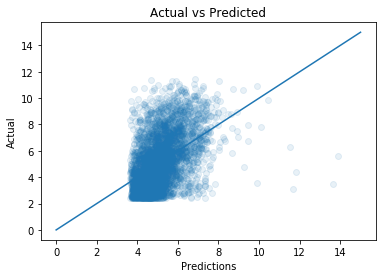

In [28]:
predict2 = fit2.predict(sm.add_constant(X2_train))
plt.scatter(predict2,y2_train,alpha=.1)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot(np.linspace(0,15,100),np.linspace(0,15,100))
plt.title('Actual vs Predicted')

## Diagnostic Plots

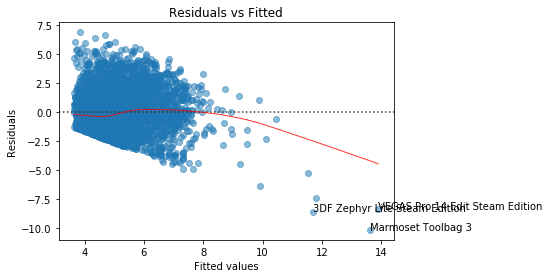

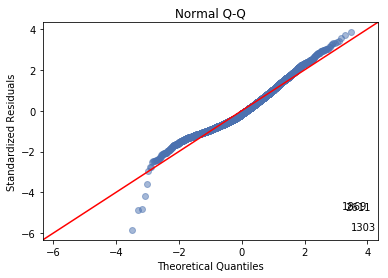

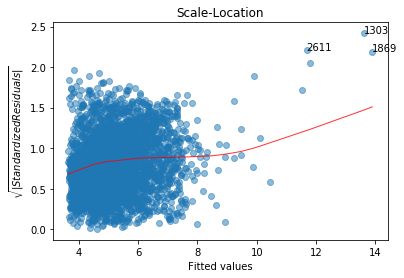

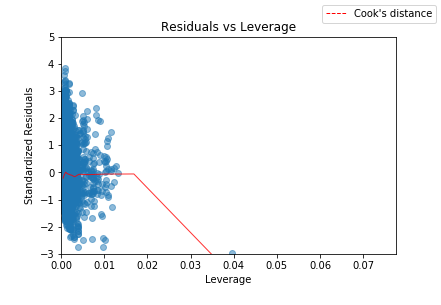

In [29]:
y_traindf2=pd.DataFrame(y2_train)
X_traindf2=pd.DataFrame(X2_train)
diagnostic_plots.diagnostic_plots(X_traindf2, y_traindf2, fit2)

# 10. Add Polynomial Features

In [30]:
X2_poly = X2_train[['release_date', 'price']]
poly = PolynomialFeatures(2)
X2_polynomialfeatures = poly.fit_transform(X2_poly)

In [31]:
X2_polynomialfeaturesdf = pd.DataFrame(X2_polynomialfeatures, columns=[list(poly.get_feature_names())])
X2_polynomialfeaturesdf.index=X2_train.index
X2_polynomialfeaturesdf.head()

,1,x0,x1,x0^2,x0 x1,x1^2
title,,,,,,
ATOMINE,1.0,439.0,9.99,192721.0,4385.61,99.8001
Nidhogg,1.0,1646.0,9.99,2709316.0,16443.54,99.8001
Starship Rubicon,1.0,1100.0,9.99,1210000.0,10989.00,99.8001
All Contact Lost,1.0,117.0,14.99,13689.0,1753.83,224.7001
"Papers, Please",1.0,1804.0,9.99,3254416.0,18021.96,99.8001


In [32]:
X2_polynomialfeatures = pd.DataFrame(X2_polynomialfeatures, columns=[['constant','release_date','price','release_date^2','price*release_date','price^2']]) 
X2_polynomialfeatures.index=X2_train.index
X2_polynomialfeatures.head()

,constant,release_date,price,release_date^2,price*release_date,price^2
title,,,,,,
ATOMINE,1.0,439.0,9.99,192721.0,4385.61,99.8001
Nidhogg,1.0,1646.0,9.99,2709316.0,16443.54,99.8001
Starship Rubicon,1.0,1100.0,9.99,1210000.0,10989.00,99.8001
All Contact Lost,1.0,117.0,14.99,13689.0,1753.83,224.7001
"Papers, Please",1.0,1804.0,9.99,3254416.0,18021.96,99.8001


In [33]:
polydf_x=X2_train[['mac','linux','discount']].join(X2_polynomialfeatures)
polydf_x.head()

,mac,linux,discount,"(constant,)","(release_date,)","(price,)","(release_date^2,)","(price*release_date,)","(price^2,)"
title,,,,,,,,,
ATOMINE,0,0,80,1.0,439.0,9.99,192721.0,4385.61,99.8001
Nidhogg,1,0,0,1.0,1646.0,9.99,2709316.0,16443.54,99.8001
Starship Rubicon,1,1,0,1.0,1100.0,9.99,1210000.0,10989.00,99.8001
All Contact Lost,0,0,0,1.0,117.0,14.99,13689.0,1753.83,224.7001
"Papers, Please",1,1,0,1.0,1804.0,9.99,3254416.0,18021.96,99.8001


In [34]:
polydf_train=polydf_x.join(y2_train)
polydf_train.head()

,mac,linux,discount,"(constant,)","(release_date,)","(price,)","(release_date^2,)","(price*release_date,)","(price^2,)",log_reviews
title,,,,,,,,,,
ATOMINE,0,0,80,1.0,439.0,9.99,192721.0,4385.61,99.8001,4.442651
Nidhogg,1,0,0,1.0,1646.0,9.99,2709316.0,16443.54,99.8001,8.380457
Starship Rubicon,1,1,0,1.0,1100.0,9.99,1210000.0,10989.00,99.8001,2.772589
All Contact Lost,0,0,0,1.0,117.0,14.99,13689.0,1753.83,224.7001,3.044522
"Papers, Please",1,1,0,1.0,1804.0,9.99,3254416.0,18021.96,99.8001,9.962087


# 11. EDA on Data with Polynomial Features; Log Reviews as Dependent

## Pairplot

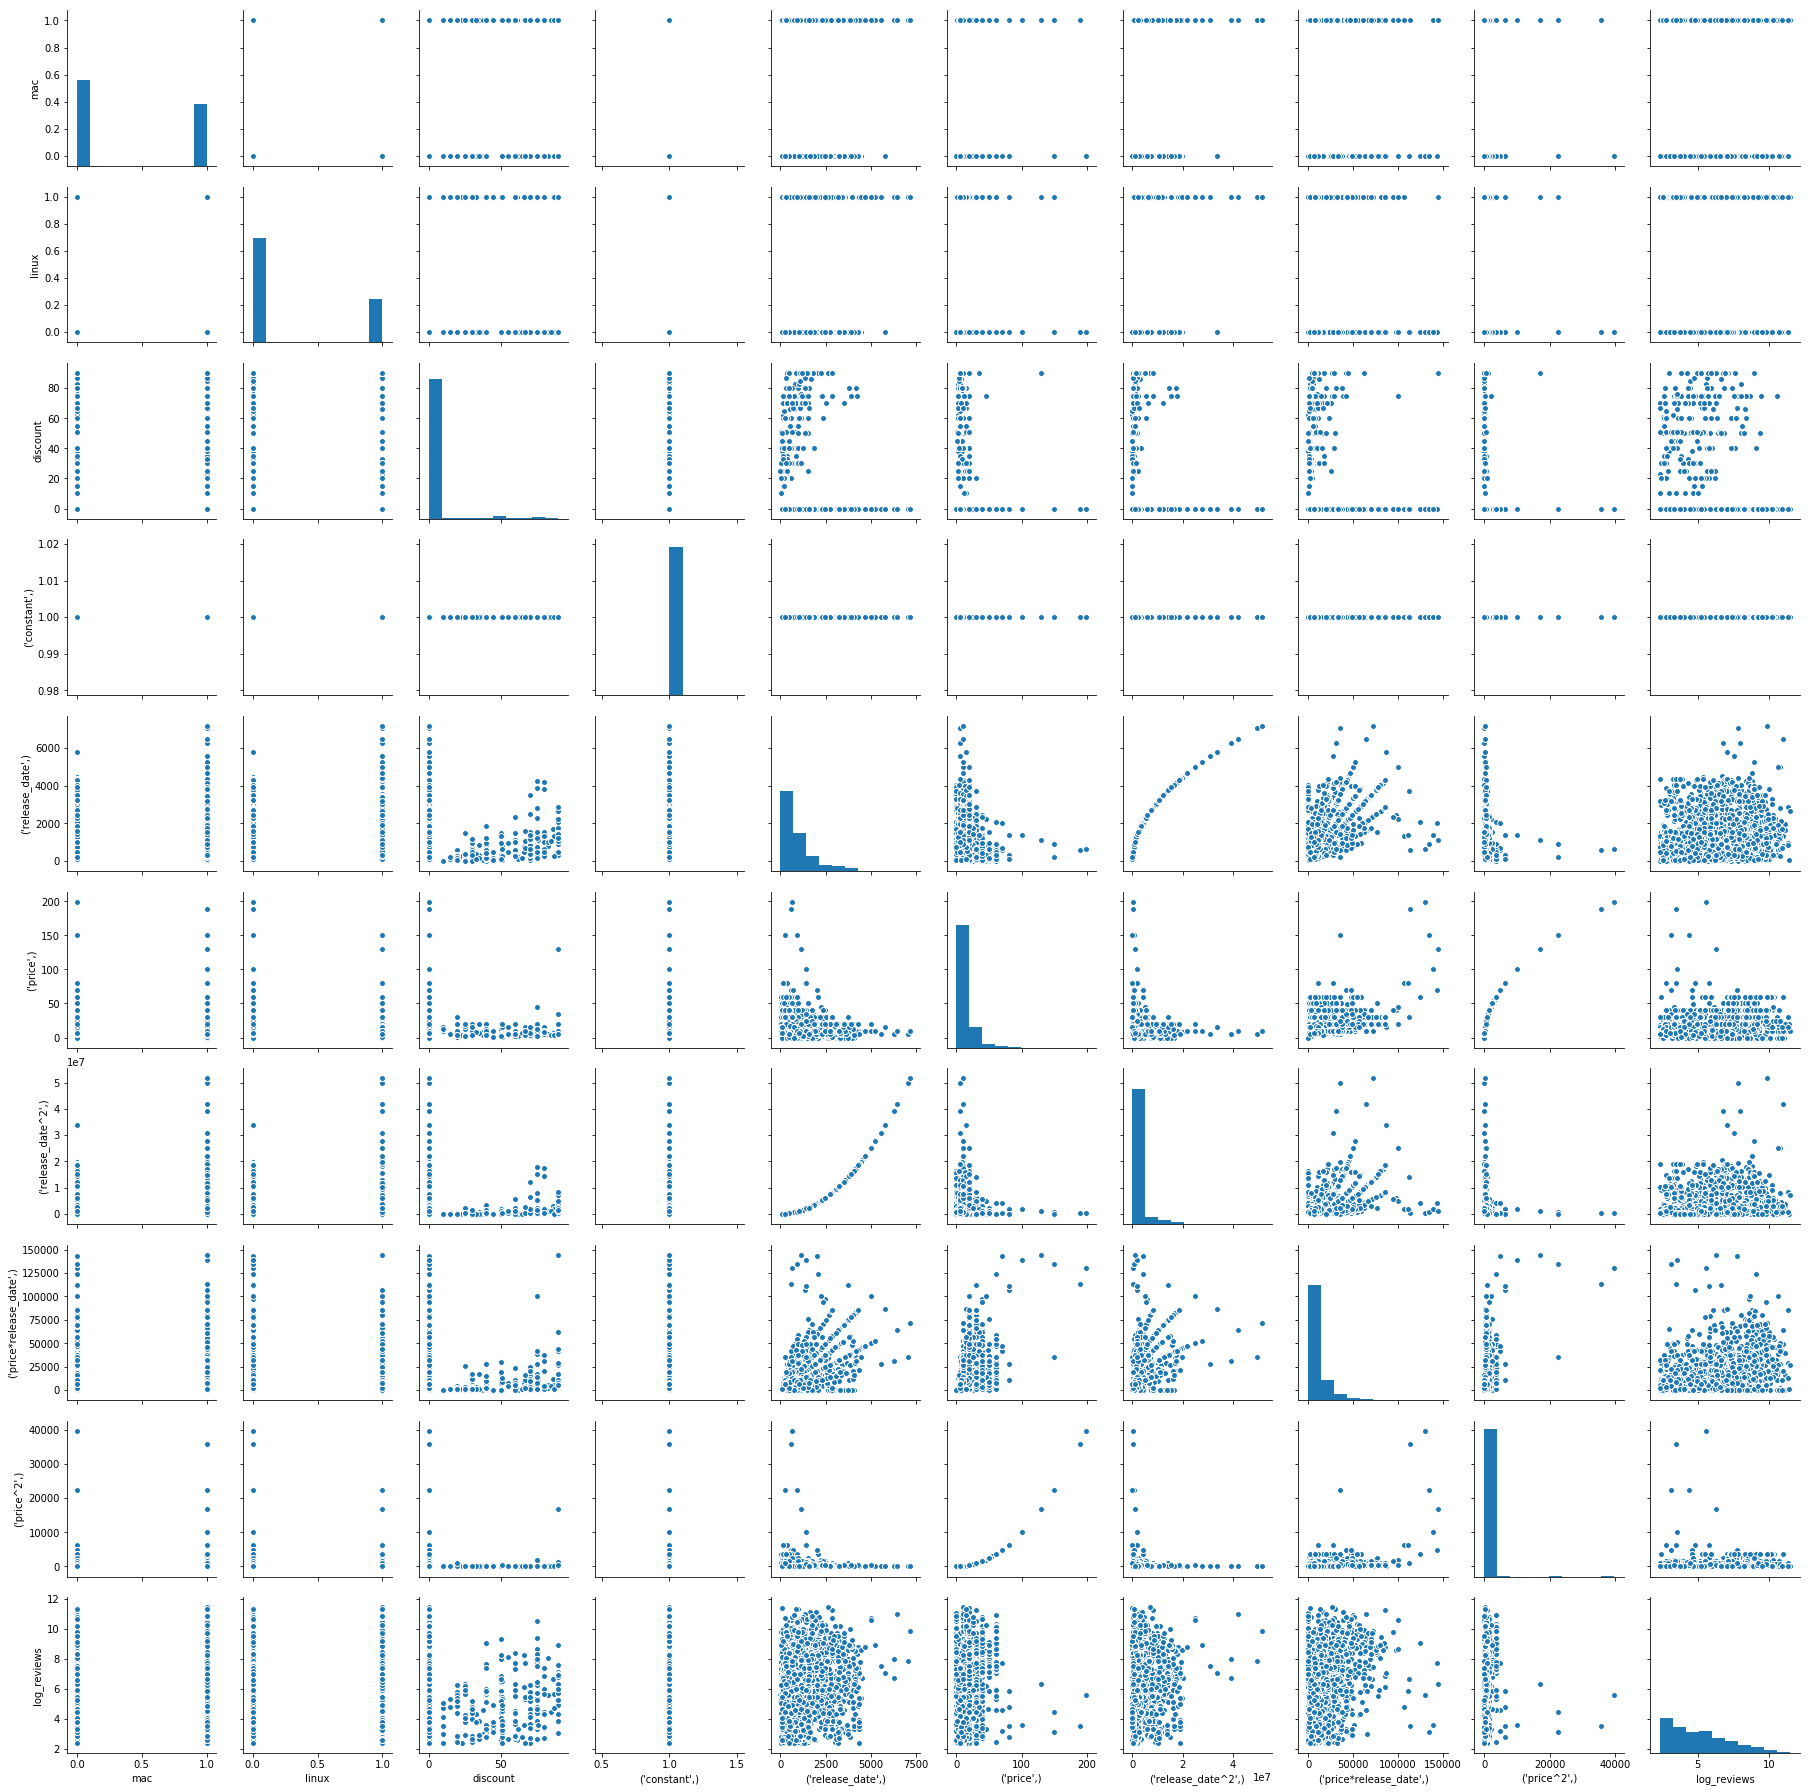

In [35]:
sns.pairplot(polydf_train)

## Correlation Matrix

In [36]:
polydf_train.corr()

,mac,linux,discount,"(constant,)","(release_date,)","(price,)","(release_date^2,)","(price*release_date,)","(price^2,)",log_reviews
mac,1.000000,0.669688,-0.001116,NaN,0.044060,-0.033826,-0.007278,0.022111,-0.022712,0.125898
linux,0.669688,1.000000,0.001781,NaN,0.010804,-0.025136,-0.026282,-0.003984,-0.022352,0.121375
discount,-0.001116,0.001781,1.000000,NaN,-0.018523,-0.046198,-0.018663,-0.016912,-0.005706,-0.019095
"(constant,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(release_date,)",0.044060,0.010804,-0.018523,NaN,1.000000,0.009218,0.921418,0.655421,-0.025747,0.366296
"(price,)",-0.033826,-0.025136,-0.046198,NaN,0.009218,1.000000,-0.002334,0.573317,0.770961,0.275716
"(release_date^2,)",-0.007278,-0.026282,-0.018663,NaN,0.921418,-0.002334,1.000000,0.577859,-0.026705,0.279015
"(price*release_date,)",0.022111,-0.003984,-0.016912,NaN,0.655421,0.573317,0.577859,1.000000,0.400749,0.429736
"(price^2,)",-0.022712,-0.022352,-0.005706,NaN,-0.025747,0.770961,-0.026705,0.400749,1.000000,0.098506
log_reviews,0.125898,0.121375,-0.019095,NaN,0.366296,0.275716,0.279015,0.429736,0.098506,1.000000


# 12. Regression with Polynomial Features on Log Values

## OLS Model

In [37]:
y2_train_poly = polydf_train['log_reviews']

model3 = sm.OLS(y2_train_poly, sm.add_constant(polydf_x))
fit3 = model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_reviews   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     183.5
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          1.35e-264
Time:                        19:45:09   Log-Likelihood:                -7861.9
No. Observations:                3984   AIC:                         1.574e+04
Df Residuals:                    3975   BIC:                         1.580e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
mac                         0.2191      0.076      2.891      0.004       0.071       0.368
linux                       0.3422      0.082      4.193      0.000       0.182       0.502
discount                    0.0007      0.002      0.353      0.724      -0.003       0.005
('constant',)               3.2395      0.071     45.371      0.000       3.100       3.380
('release_date',)           0.0013   9.05e-05     14.126      0.000       0.001       0.001
('price',)                  0.0723      0.005     15.102      0.000       0.063       0.082
('release_date^2',)      -1.74e-07   1.97e-08     -8.815      0.000   -2.13e-07   -1.35e-07
('price*release_date',)  1.298e-05   3.84e-06      3.384      0.001    5.46e-06    2.05e-05
('price^2',)               -0.0004   3.85e-05    -11.419      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      238.377   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.366
Skew:                           0.625   Prob(JB):                     4.84e-62
Kurtosis:                       3.373   Cond. No.                     1.49e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## K-Fold CV

### 10-fold Cross Validation Split

In [38]:
kf3=KFold(n=len(polydf_x), n_folds=10, shuffle=True, random_state=20)

### Calculate Avg Score Across Folds

In [39]:
score(kf3,polydf_x,y2_train_poly)

('train score mean: 0.26992382242502166',
 'test score mean: 0.26144790814218544')

## Plot Predicted vs Actual

Text(0.5,1,'Actual vs Predicted')

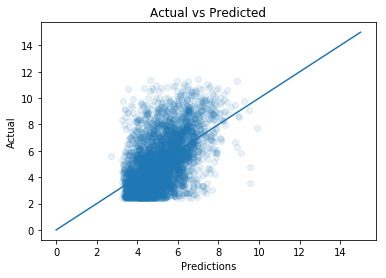

In [40]:
predict3 = fit3.predict(sm.add_constant(polydf_x))
plt.scatter(predict3,y2_train_poly,alpha=.1)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot(np.linspace(0,15,100),np.linspace(0,15,100))
plt.title('Actual vs Predicted')

## Diagnostic Plots

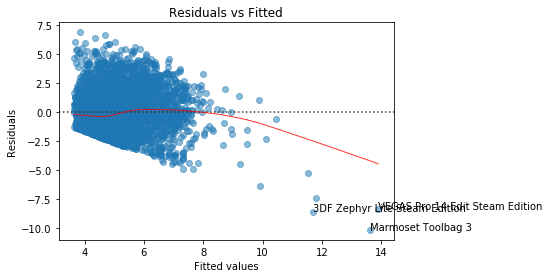

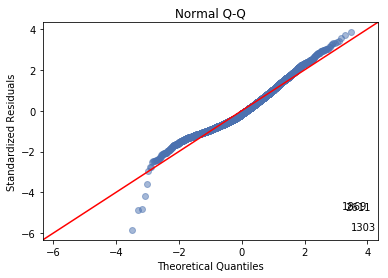

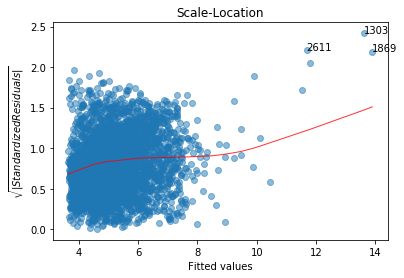

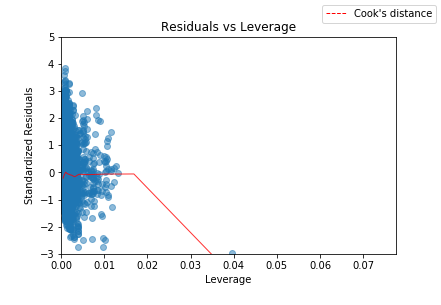

In [41]:
diagnostic_plots.diagnostic_plots(polydf_x, y2_train_poly, fit2)

# 13. Compare Different Models

## Function to Compare Each Model's Mean R2 Within Folds

In [42]:
def get_scores(X, y, kf, alpha = 0.5): 

    models = {}
    parameters = {}
    
    models['linear_model'] = linear_model.LinearRegression()
    models['ridge_model'] = linear_model.Ridge()
    models['lasso_model'] = linear_model.Lasso(alpha=alpha)
    models['lasso_cv_model'] = linear_model.LassoCV()
    models['robust_regression'] = linear_model.SGDRegressor(loss='huber',max_iter=2000)
    models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',max_iter=2000)
    models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
    models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
    models['randomForest'] = ensemble.RandomForestRegressor()
    models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
    models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()
     
    overall_scores_train=[]
    overall_scores_test=[]
    for name,model in models.items():
        scores_train=[]
        scores_test=[]
        for train, test in kf:
            Xt_train = X.iloc[train]
            yt_train=y.iloc[train]
            X_val = X.iloc[test]
            y_val = y.iloc[test]

            model.fit(Xt_train, yt_train)
            
            scores_train.append(model.score(Xt_train,yt_train))
            scores_test.append(model.score(X_val,y_val))

        overall_scores_train.append(np.mean(scores_train))
        overall_scores_test.append(np.mean(scores_test))
    
    scores_df = pd.DataFrame({'Model': list(models.keys()),
                             'Train Scores': overall_scores_train, 'Test Scores': overall_scores_test})

    return scores_df

### Compare with Unlogged Data

In [43]:
get_scores(X_train,y_train, kf)

,Model,Train Scores,Test Scores
0,linear_model,0.068727,0.059049
1,ridge_model,0.068723,0.059052
2,lasso_model,0.068713,0.059052
3,lasso_cv_model,0.060778,0.052414
4,robust_regression,-0.029114,-0.028645
5,eps_insensitive,-0.032522,-0.033076
6,cart,0.480879,-0.182738
7,extratrees,0.214847,0.001232
8,randomForest,0.782570,-0.262243
9,adaboostedTrees,-0.769613,-1.015483


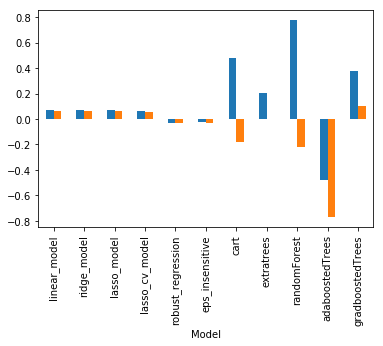

In [55]:
comparison=get_scores(X_train,y_train, kf)
comparison.set_index('Model', inplace=True)
comparison.plot(kind='bar', legend=False)

### Compare with Logged/Modified Data

In [44]:
get_scores(X2_train, y2_train, kf2)

,Model,Train Scores,Test Scores
0,linear_model,0.226376,0.218084
1,ridge_model,0.226376,0.218086
2,lasso_model,0.208050,0.201406
3,lasso_cv_model,0.207640,0.201171
4,robust_regression,-249.042788,-261.990056
5,eps_insensitive,-6551.210947,-6896.799555
6,cart,0.447458,0.293424
7,extratrees,0.301127,0.245844
8,randomForest,0.842355,0.190102
9,adaboostedTrees,0.275180,0.256332


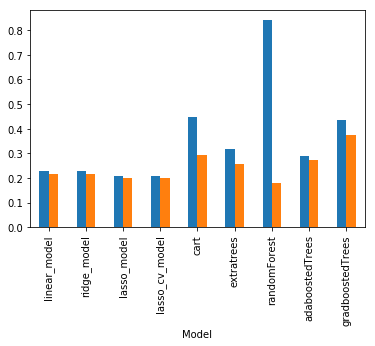

In [54]:
comparison_log=get_scores(X2_train, y2_train, kf2)
comparison_log_clean=comparison_log.drop(index=[4,5])
comparison_log_clean.set_index('Model', inplace=True)
comparison_log_clean.plot(kind='bar', legend=False)

### Compare using Polynomial Features

In [45]:
get_scores(polydf_x, y2_train_poly, kf3)

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.189933e-17
  overwrite_a=True).T
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.100407e-17
  overwrite_a=True).T
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.034664e-17
  overwrite_a=True).T
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal

,Model,Train Scores,Test Scores
0,linear_model,2.699238e-01,2.614479e-01
1,ridge_model,2.699238e-01,2.614498e-01
2,lasso_model,2.541099e-01,2.468030e-01
3,lasso_cv_model,1.788679e-01,1.741990e-01
4,robust_regression,-2.581792e+16,-2.633830e+16
5,eps_insensitive,-8.147604e+18,-8.259078e+18
6,cart,4.451296e-01,2.804928e-01
7,extratrees,3.724414e-01,2.980995e-01
8,randomForest,8.417315e-01,1.753434e-01
9,adaboostedTrees,2.924470e-01,2.707446e-01


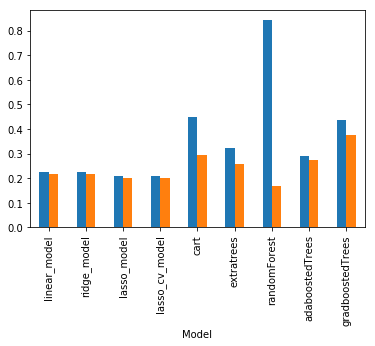

In [56]:
comparison_log_poly=get_scores(X2_train, y2_train, kf2)
comparison_log_poly_clean=comparison_log_poly.drop(index=[4,5])
comparison_log_poly_clean.set_index('Model', inplace=True)
comparison_log_poly_clean.plot(kind='bar', legend=False)

## Result: Gradient Boosted Trees is "Best" Model

# 14. Play with Model to Determine "Best" Input Values and Run on Entire Training Data
Best Input in Terms of Mean Score on Test Data Folds

In [46]:
gb = ensemble.GradientBoostingRegressor(alpha=0.9, n_estimators=200, min_samples_split=2, max_depth=3)
cross_val_score(gb, X2_train, y2_train, cv = 10, n_jobs=1, scoring="r2").mean()

0.3669683999161718

# 15. Run Gradient Boosted Trees on Holdout Set- Get Scores

In [47]:
testdf=X_test.join(y_test)
testdf['log_reviews'] = np.log(testdf.reviews + 1)

y2_test = testdf['log_reviews']
X2_test = testdf.drop(['log_reviews','reviews', 'system', 'windows'], axis = 1)

gb.fit(X2_train, y2_train)
print(gb.score(X2_train, y2_train))
print(gb.score(X2_test, y2_test))

#High bias and high variance

0.4697857421959387
0.25950088052040865


# 16. Plot Final Results

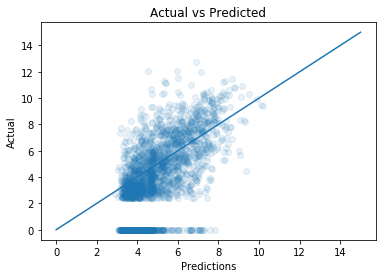

In [48]:
predictions = gb.predict(X2_test)
plt.scatter(predictions,y2_test,alpha=.1)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot(np.linspace(0,15,1000),np.linspace(0,15,1000));
plt.title('Actual vs Predicted');